This notebook handles **most** of the downloading, loading, parsing, joining, and saving the combined [PLUTO](http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page), [Rolling Sales](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page), and [RPAD](https://www1.nyc.gov/site/finance/taxes/property-assessments.page) datasets. A bit of the work is done out-of-band&mdash;you'll see why.

Note that in all of these datasets the unit of measurement is a borough-block-lot combination, each of which maps uniquely to an individual property. That property may be a building (in the case of actual buildings, small homes, and co-ops) or it may be an apartment (in the case of condominiums). None of the three datasets provide information on the size of individual apartments, though assessment values and market values are present in the RPAD and Rolling Sales datasets, respectively. Therefore there is no way to map information on apartment values. These records are removed at a later step. The focus of this project therefore is on whole-building values.

Now on to the datasets.

RPAD is a record of the assessed value, as determined by the New York City Department of Finance and used for taxation purposes, of every building and apartment in New York City. These assessed values are by the department's own admission generally a few cycles or years behind the trend of the market, but are nevertheless a valuable and almost complete record of all property values in New York City.

The PLUTO dataset agglomerates a large number of datasets published by various agencies in New York City into a single master record for categorical information on every property in New York City. It gives RPAD and Rolling Sales information a rich context.

Rolling Sales contains the actual market prices of all buildings sold in New York City in the last twelve months. Past that horizon real estate market trends make this data less concrete. Since market value is our target variable, Rolling Sales contains ground truths about what we would like to model. On the other hand it also contains a significant amount of noise, dealing with which will be discussed later.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import zipfile
import io

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

# Download

Rolling sales data is provided as lightly formatted `xls` files (Excel):

![alt text](./rolling-sales-data-excel-screencap.png "")

Luckily the extraneous details are easily patched up post-import.

In [3]:
rolling_sales_data = dict()
rolling_sales_data_key_pairs = {'Manhattan': 'manhattan',
                                'Brooklyn': 'brooklyn',
                                'Queens': 'queens',
                                'Bronx': 'bronx',
                                'Staten Island': 'statenisland'}
for b_k, b_xls in tqdm(list(rolling_sales_data_key_pairs.items())):
    borough_rsd = pd.read_excel('https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_{0}.xls'.format(b_xls))
    borough_rsd.columns = borough_rsd.iloc[3].values
    borough_rsd = borough_rsd[4:]
    rolling_sales_data[b_k] = borough_rsd

PLUTO data is provided as borough-denominated `csv` files packaged into a `zip`. The following code bit unpacks the data and rekeys the file (`QN.csv`, `BK.csv`, `BX.csv`, `SI.csv`, `Mn.csv`) to match the lexicon used for the rolling sales data, above.

In [5]:
r = requests.get('http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v1.zip')
pluto_key_pairs = {'Manhattan': 'MN.csv',
                   'Brooklyn': 'BK.csv',
                   'Bronx': 'BX.csv',
                   'Staten Island': 'SI.csv',
                   'Queens': 'QN.csv'}
pluto_data = dict()
for b_k, b_csv in tqdm(list(pluto_key_pairs.items())):
    with zipfile.ZipFile(io.BytesIO(r.content)) as ar:
        borough_pluto = pd.read_csv(ar.open(b_csv))
        pluto_data[b_k] = borough_pluto

  0%|          | 0/5 [00:00<?, ?it/s]/Users/Honors/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (18,19,21,22,65,66,78,81) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 20%|██        | 1/5 [00:07<00:29,  7.34s/it]/Users/Honors/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (19,22,23,24,81) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 40%|████      | 2/5 [00:08<00:16,  5.43s/it]/Users/Honors/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (18,19,21,22,24,65,66,81) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 60%|██████    | 3/5 [00:14<00:11,  5.56s/it]/Users

Both the PLUTO and Rolling Sales datasets provide their data on a per-borough basis, and since we would like to study the entire city, we must now flatten each set of tables into two big tables. Along the way we encode an additional `Borough` column, to preserve information.

**Note**: the `Borough` mapping is a new column in the rolling sales dataset; a prexisting (numerically encoded) `BOROUGH` column is removed. The mapping overlays and replaces an older (acronym-encoded) column in the `PLUTO` one.

In [6]:
rolling_sales_agglom = pd.DataFrame(columns=rolling_sales_data['Manhattan'].columns)
pluto_data_agglom = pd.DataFrame(columns=pluto_data['Manhattan'].columns)
for b_k in tqdm(pluto_key_pairs.keys()):
    pluto_data[b_k]['Borough'] = rolling_sales_data[b_k]['Borough'] = b_k
    rolling_sales_agglom = pd.concat([rolling_sales_agglom, rolling_sales_data[b_k]], ignore_index=True)
    pluto_data_agglom = pd.concat([pluto_data_agglom, pluto_data[b_k]], ignore_index=True)
del rolling_sales_agglom['BOROUGH']

RPAD data is the trickiest. RPAD is split into two files, one for properties in tax class 1 (single, double, and triple -family homes) and one for those in tax classes 2/3/4 (everything else). These are provided as compressed `zip` files containing `mdb` database files (for Microsoft Access).

I handled this the easiest way I could: by jumping on a Windows Desktop, opening the databases, opening them in Microsoft Access, and exporting them to comma-delimited `txt` files using the GUI (be sure to check the box that asks if you'd like to include the field name in the first column!). There are automated ways of doing this but they're sure to be painful and this is easiest. The resulting files can then be read by `pandas`.

Check out [mdbtools](https://github.com/brianb/mdbtools) (the [homebrew installation](http://brewformulas.org/Mdbtools) for Mac OS X) for \*nix systems (not sure what the easiest way to get it on Linux is). If you're working on Windows and don't have access to Microsoft Access (heh), I'm not sure but I think [pyodbc](https://github.com/mkleehammer/pyodbc) will work.

The odd filenames come from the odd names the underlying database for its tables. They stand for tax class 1 and tax classes 2/3/4.

In [7]:
%ls

both-tabs-and-commas-screencap.png      nyc_neighborhoods.geojson
data-munging.ipynb                      nyc_pluto.csv
data-scribbles.ipynb                    nyc_rolling_sales.csv
data-visualization.ipynb                rolling-sales-data-excel-screencap.png
nyc_building_sales.csv                  tc1.txt*
nyc_buildings.csv*                      tc234.txt*


In [8]:
rpad_data_agglom = pd.concat([pd.read_csv("tc1.txt"), pd.read_csv("tc234.txt")], ignore_index=True)

/Users/Honors/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0,4,53,87,90,93,97,100,106,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Honors/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (45,46,77,90,97,100,103,106,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Merge

Now we flatten these two files into one by performing an outer join on the `(Borough, Block, Lot)` unique key (this is *supposedly* [standard](http://www1.nyc.gov/nyc-resources/service/1232/borough-block-lot-bbl-lookup) but turned out to be far far harder than anticipated&mdash;keep reading for more on why).

In order to do this we first remap the column names in the rolling sales dataset from `SPACED ALL CAPS` to `NoSpaceCamelCase` (as used by `PLUTO`).

In [9]:
rolling_sales_agglom.columns = [c.title().replace(' ', '') for c in list(rolling_sales_agglom.columns)]

Not every record in the Rolling Sales dataset represents an actual sale. A large number of records are of what are effectively deed transfers: sales of a building for either `$0` or occassionally some paltry some, usually between family members, sometimes as a part of a contract, and so on. Since these records do not encode any actual information they should be dropped.

`$1000` is arbitrarily chosen as a cutoff value.

In [10]:
rolling_sales_agglom = rolling_sales_agglom[rolling_sales_agglom['SalePrice'] > 1000]

The Rolling Sales dataset contains information on the sale of both individual apartments and of whole buildings, but does not contain the square footage of the apartment sales in the data. Since we need this for calculating standardized value per square foot, we have to throw out apartments entirely, unfortunately, from the dataset.

To do this we remove entries with no defined `LandSquareFeet` (no apartments have this value in any of the datasets, weirdly enough) and restrict apartment number to a lack of one, which is weirdly `'            '`, as in, a long space. See [Cleaning](#Cleaning) for more on why.

In [11]:
rolling_sales_agglom.ix[0, :]['ApartmentNumber']

'            '

In [12]:
rs_a_f = rolling_sales_agglom[rolling_sales_agglom['ApartmentNumber'] == '            ']

In [13]:
rs_a_f = rs_a_f[rs_a_f['LandSquareFeet'] > 0]

Our assumption going into this project was that the `Borough`-`Block`-`Lot` columns present in both PLUTO and the Rolling Sales dataset (these are an identifier used for taxation purposes) are equivalent, allowing us to use this combo as a unique key for a join. However, this assumption turns out to be incorrect. Both PLUTO and Rolling Sales break this assumption, and in different ways.

The PLUTO dataset contains information on the square footage of entire buildings, but not on that of individual units. This is because instead of using the usual Tax-Block-Lot system PLUTO defines and uses its own Lot configuration, painting over condominiums with multiple lots in a single building by merging them into one Lot. This is useful for geospatial visualization but voids the use of the dataset for ordinary apartment-based residential lookup: the Rolling Sales dataset contains sales information on individual apartments which, as a consequence of this tweak, cannot be mapped to any of the records in PLUTO.

That doesn't really bother us though&mdash;apartments were already disqualified by the fact that nowhere is there a data stream for their size, without which their price cannot be standardized.

Rolling Sales breaks the uniqueness assumption by, bizarrely enough, allowing the sale of sub-units within a single property block. This is really disorienting: isn't the whole point of having a single identifier that it's atomic? Apparently in the city's eyes, no. And thus it is that individual sales of components of a property are all recorded seperately!

How do we handle this? `Rolling Sales` contains both the `SalePrice` and the square footage of the property sold. Instead of working with `SalePrice` directly, we will compute an average `MarketValueSqFt` based on the sum of the `SalePrice` fields divided by the sum of the `BldgArea` fields for each unique `Borough`-`Block`-`Lot` combination in the dataset.

In [14]:
# This function is a doozy! Here' what it does, step-by-step:
# 1. Select our desired slice of the variables from the rolling sales data.
# 2. Aggregate by Borough-Block-Lot, creating a groupby object.
# 3. Merge the non-key variables via summation, converting the groupby object to the hierarchical DataFrame.
# 4. Reset the index to shake off the hierarchical index and recreate a simple numerical one.
# 5. Assign all of that to rs_a_ff.
rs_a_ff = rs_a_f[['Borough', 'Block', 'Lot', 'SalePrice', 'LandSquareFeet']].groupby(by=['Borough', 'Block', 'Lot']).sum().reset_index()
# Now all that's left is to create a new column for market value by broadcasting division.
rs_a_ff['MarketValueSqFt'] = rs_a_ff['SalePrice'] / rs_a_ff['LandSquareFeet']

How many records did we fold this way?

In [15]:
len(rs_a_f) - len(rs_a_ff)

1692

Now the join.

In [16]:
rolling_pluto = pd.merge(rs_a_ff, pluto_data_agglom,
                         how='outer', on=['Borough', 'Block', 'Lot'])

It's not immediately apparent why, but this resulted in slightly more records than expected.

**Edit**: Merging against PLUTO version 16v1 instead of 15v1 resulted in *no* dropped records!

In [17]:
len(rolling_pluto) - len(pluto_data_agglom)

0

Should we be worried about 71 records amongst 859535 of them? Probably not.

And `SalePrice`-populated mergers fired correctly.

In [18]:
len(rs_a_ff) - len(rolling_pluto[rolling_pluto['SalePrice'] >= 0])

0

Next up we want to merge in the RPAD dataset. RPAD has a borough column much like the Rolling Sales dataset&mdash;numbers instead of the borough names that we need to join it to `rolling_pluto`. Since the data isn't provided on a borough-denominated basis, in this case we'll have to explicitly map the `BORO` numerical column to a name value.

In [19]:
rpad_key_pairs = {1.0: 'Manhattan',
                  2.0: 'Bronx',
                  3.0: 'Brooklyn',
                  4.0: 'Queens',
                  5.0: 'Staten Island',
                 }
rpad_data_agglom['Borough'] = rpad_data_agglom['BORO'].apply(lambda n: rpad_key_pairs[n])
del rpad_data_agglom['BORO']

Again this dataset has its own format for variables, in this case the format is `ALL_CAPS_SPACERS`. Again we convert to `CamelCase`.

In [20]:
rpad_data_agglom.columns = [c.title().replace('_', '') for c in list(rpad_data_agglom.columns)]

In [21]:
rpad_data_agglom.head(5)

,Bble,Block,Lot,Ease,Secvol,District,Year4,CurFvL,CurFvT,NewFvL,NewFvT,FvChgdt,Curavl,Curavt,Curexl,Curext,CuravlA,CuravtA,CurexlA,CurextA,Chgdt,TnAvl,TnAvt,TnExl,TnExt,TnAvlA,TnAvtA,TnExlA,TnExtA,Fchgdt,FnAvl,FnAvt,FnExl,FnExt,FnAvlA,FnAvtA,FnExlA,FnExtA,Txcl,OTxcl,CbnTxcl,Bldgcl,Exmtcl,Owner,HnumLo,HnumHi,StrName,Zip,TotUnit,ResUnit,LfrtDec,LdepDec,LAcre,Irreg,BfrtDec,BdepDec,BldVar,Ext,Story,Bldgs,Corner,LndArea,GrSqft,Zoning,Yrb,YrbFlag,YrbRng,Yra1,Yra1Rng,Yra2,Yra2Rng,CpBoro,CpDist,Limit,OLimit,Status1,Status2,Newlot,Droplot,Delchg,Corchg,Nodesc,Noav,Valref,Mbldg,CondoNm,CondoS1,CondoS2,CondoS3,CondoA,ComintL,ComintB,Aptno,ApBoro,ApBlock,ApLot,ApEase,ApDate,ApTime,Protest,AtGrp,Applic,Protest2,AtGrp2,Applic2,OProtst,OAtGrp,OApplic,Reuc,GeoRc,CoopNum,ExInds,ExCount,ExChgdt,Dchgdt,SmChgdt,Borough
0,1000750043,75.0,43.0,NaN,102.0,1.0,2015.0,5690000.0,7042000.0,5456000.0,6837000.0,12/16/2015,206643.0,255744.0,0.0,0.0,206643.0,255744.0,0.0,0.0,12/16/2015,207764.0,260352.0,0.0,0.0,207764.0,260352.0,0.0,0.0,00/00/0000,207764.0,260352.0,0.0,0.0,207764.0,260352.0,0.0,0.0,1,1,NaN,C0,NaN,"YUEN, SO SAN",000000000026,000000000026,CLIFF STREET,10038.0,3.0,3.0,19.42,89.33,NaN,I,20.00,80.0,NaN,NaN,4.0,1.0,NaN,1690.0,6400.0,C6-4,1974.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,NaN,0.0,00/00/0000,03/19/2009,12/16/2015,Manhattan
1,1000780040,78.0,40.0,NaN,102.0,1.0,2015.0,4620000.0,7076000.0,4620000.0,6015000.0,11/10/2015,169234.0,259200.0,0.0,0.0,169234.0,259200.0,0.0,0.0,11/10/2015,199086.0,259200.0,0.0,0.0,199086.0,259200.0,0.0,0.0,00/00/0000,199086.0,259200.0,0.0,0.0,199086.0,259200.0,0.0,0.0,1,1,NaN,S2,NaN,"H.B.S. EQUITIES,",000000000086,000000000086,NASSAU STREET,10038.0,3.0,2.0,16.58,51.75,NaN,I,19.00,52.0,NaN,NaN,5.0,1.0,NaN,854.0,4140.0,C5-5,1910.0,E,0.0,2004.0,0.0,2004.0,0.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,NaN,0.0,00/00/0000,03/22/2007,11/10/2015,Manhattan
2,1000970017,97.0,17.0,NaN,103.0,1.0,2015.0,2990000.0,5088000.0,2990000.0,5088000.0,00/00/0000,128944.0,219420.0,0.0,0.0,128944.0,219420.0,0.0,0.0,06/09/2015,136680.0,232585.0,0.0,0.0,136680.0,232585.0,0.0,0.0,00/00/0000,136680.0,232585.0,0.0,0.0,136680.0,232585.0,0.0,0.0,1,1,NaN,S1,NaN,"SPAEDA, DORATHEA S.",000000000211,000000000211,FRONT STREET,10038.0,2.0,1.0,25.00,39.83,NaN,I,25.00,40.0,NaN,NaN,5.0,1.0,NE,992.0,4960.0,C6-2A,1900.0,E,0.0,1981.0,0.0,2005.0,0.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,8,115.0,1.0,NaN,0.0,NaN,8,115.0,1.0,NaN,0,0.0,NaN,0.0,00/00/0000,03/17/2015,06/09/2015,Manhattan
3,1000970036,97.0,36.0,NaN,103.0,1.0,2015.0,3950000.0,7401000.0,3950000.0,6291000.0,11/10/2015,77654.0,145499.0,1580.0,1580.0,77654.0,145499.0,1580.0,1580.0,01/08/2016,94325.0,150228.0,1550.0,1550.0,94325.0,150228.0,1550.0,1550.0,00/00/0000,94325.0,150228.0,1550.0,1550.0,94325.0,150228.0,1550.0,1550.0,1,1,NaN,S2,NaN,"BARNET, ANDREA",000000000226,000000000226,FRONT STREET,10038.0,3.0,2.0,25.08,71.00,NaN,I,25.08,71.0,NaN,NaN,4.0,1.0,NaN,1775.0,6600.0,C6-2A,1901.0,E,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,8,18.0,1.0,NaN,0,0.0,EEEE,1.0,00/00/0000,03/26/2008,11/10/2015,Manhattan
4,1000970044,97.0,44.0,NaN,103.0,1.0,2015.0,1530000.0,1983000.0,1836000.0,2677000.0,12/16/2015,45239.0,58633.0,0.0,0.0,45239.0,58633.0,0.0,0.0,12/16/2015,40531.0,59097.0,0.0,0.0,40531.0,59097.0,0.0,0.0,00/00/0000,40531.0,59097.0,0.0,0.0,40531.0,59097.0,0.0,0.0,1,1,NaN,A9,NaN,"136 BEEKMAN, LLC",000000000136,000000000138,BEEKMAN STREET,10038.0,1.0,1.0,18.69,25.58,NaN,I,18.60,25.5,NaN,NaN,4.0,1.0,NaN,477.0,1900.0,C6-2A,1998.0,NaN,1999.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,Na

The variables of interest in RPAD (what we want to keep after the merge) are:

* Borough (merge key).
* Block (merge key).
* Lot (merge key).
* CurFvT &mdash; Current market value, total, as of assessment sometime in 2015 and as determined by the city. This is the Finance office's best guess as to the value of this property.
* NewFvT &mdash; New market value, total, as of prospective assessment in early 2016 and as determined by the city. Note that the Finance office lags, by its own admission, generally a cycle or two behind the movements of the real estate market.
* CuravtA &mdash; current assessed value, total, as of assessment sometime in 2015 as determined by the city. Assessed value is computed using a complex and obtruse formulaic determination of rental market value. The very similar `Curavt` is a similar statistics which is rebalanced to increase no more than `20%` a year, per tax laws ([source](https://www1.nyc.gov/site/finance/taxes/property-determining-your-transitional-assessed-value.page)); it is excluded because `CuravtA` is, therefore, better correlated with actual value. `Curavt`, not market value, is what is used by the city to assess residential tax.

Tentative and final assessment information excluded because it is incomplete pending the release of this dataset for the most recent financial year.

In [22]:
rpad_columns_of_interest = ['Borough', 'Block', 'Lot', 'CurFvT', 'NewFvT', 'CuravtA']

In [24]:
counts = rpad_data_agglom.groupby(by=['Borough', 'Block', 'Lot']).count().reset_index()

In [52]:
counts = counts.sort_values(by='CurFvT', ascending=False)
counts[counts['Bble'] > 1]

,Borough,Block,Lot,Bble,Ease,Secvol,District,Year4,CurFvL,CurFvT,NewFvL,NewFvT,FvChgdt,Curavl,Curavt,Curexl,Curext,CuravlA,CuravtA,CurexlA,CurextA,Chgdt,TnAvl,TnAvt,TnExl,TnExt,TnAvlA,TnAvtA,TnExlA,TnExtA,Fchgdt,FnAvl,FnAvt,FnExl,FnExt,FnAvlA,FnAvtA,FnExlA,FnExtA,Txcl,OTxcl,CbnTxcl,Bldgcl,Exmtcl,Owner,HnumLo,HnumHi,StrName,Zip,TotUnit,ResUnit,LfrtDec,LdepDec,LAcre,Irreg,BfrtDec,BdepDec,BldVar,Ext,Story,Bldgs,Corner,LndArea,GrSqft,Zoning,Yrb,YrbFlag,YrbRng,Yra1,Yra1Rng,Yra2,Yra2Rng,CpBoro,CpDist,Limit,OLimit,Status1,Status2,Newlot,Droplot,Delchg,Corchg,Nodesc,Noav,Valref,Mbldg,CondoNm,CondoS1,CondoS2,CondoS3,CondoA,ComintL,ComintB,Aptno,ApBoro,ApBlock,ApLot,ApEase,ApDate,ApTime,Protest,AtGrp,Applic,Protest2,AtGrp2,Applic2,OProtst,OAtGrp,OApplic,Reuc,GeoRc,CoopNum,ExInds,ExCount,ExChgdt,Dchgdt,SmChgdt
5580,Bronx,2539.0,20.0,10,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,0,10,1,10,0,0,9,10,10,10,10,10,0,3,10,10,0,0,10,10,0,10,10,10,10,0,10,10,10,10,10,10,10,0,0,10,10,10,10,10,10,10,10,10,10,10,0,0,0,0,10,10,0,10,10,10,0,10,10,0,10,0,0,10,0,0,10,0,8,10,10,2,10,10,10,10
5606,Bronx,2539.0,502.0,9,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,0,9,0,9,0,0,5,9,9,9,9,9,0,6,9,9,0,0,9,9,0,9,9,9,9,0,9,9,9,9,9,9,9,0,0,9,9,9,9,9,9,9,9,9,9,9,0,0,0,0,9,9,0,9,9,9,0,9,9,0,9,0,0,9,0,0,9,0,9,9,9,0,9,9,9,9
1075136,Staten Island,6169.0,200.0,8,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,0,8,8,8,1,1,8,8,8,8,8,8,0,2,8,8,0,0,8,8,0,8,8,8,8,0,8,8,8,8,8,8,8,0,0,8,8,8,8,8,8,8,8,8,8,8,0,0,0,0,8,8,0,8,8,8,0,8,8,0,8,0,0,8,0,0,8,0,0,8,8,8,8,8,8,8
598692,Queens,65.0,4.0,7,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,0,7,0,7,1,1,7,7,7,7,7,7,0,1,7,7,0,0,7,7,0,7,7,7,7,0,7,7,7,7,7,7,7,0,0,7,7,7,7,7,7,7,7,7,7,7,0,0,0,0,7,7,0,7,7,7,0,7,7,0,7,0,0,7,0,0,7,0,6,7,7,1,7,7,7,7
951670,Queens,15845.0,44.0,7,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,0,7,7,7,0,0,7,7,7,7,7,7,1,0,7,7,0,0,7,7,0,7,7,7,7,0,7,7,7,7,7,7,7,0,0,7,7,7,7,7,7,7,7,7,7,7,0,0,0,0,7,7,0,7,7,7,0,7,7,0,7,0,0,7,0,0,7,0,2,7,7,0,7,7,7,7
598691,Queens,65.0,1.0,7,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,0,7,0,7,0,0,7,7,7,7,7,7,0,3,7,7,0,0,7,7,0,7,7,7,7,0,7,7,7,7,7,7,7,0,0,7,7,7,7,7,7,7,7,7,7,7,0,0,0,0,7,7,0,7,7,7,0,7,7,0,7,0,0,7,0,0,7,0,6,7,7,1,7,7,7,7
1074716,Staten Island,6110.0,32.0,6,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,6,6,6,1,1,6,6,6,6,6,6,0,1,6,6,0,0,6,6,0,6,6,6,6,0,6,6,6,6,6,6,6,0,0,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,6,6,0,6,6,6,0,6,6,0,6,0,0,6,0,0,6,0,0,6,6,6,6,6,6,6
1006350,Staten Island,1780.0,69.0,6,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,6,5,6,0,0,6,6,6,6,6,6,0,1,6,6,0,0,6,6,0,6,6,6,6,0,6,6,6,6,6,6,6,0,0,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,6,6,0,6,6,6,0,6,6,0,6,0,0,6,0,0,6,0,0,6,6,6,6,6,6,6
951740,Queens,15853.0,60.0,6,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,6,6,6,0,0,5,6,6,6,6,6,0,0,6,6,0,0,6,6,0,6,6,6,6,0,6,6,6,6,6,6,6,0,0,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,6,6,0,6,6,6,0,6,6,0,6,0,0,6,0,0,6,0,2,6,6,0,6,6,6,6
6461,Bronx,2599.0,87.0,6,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,6,1,6,1,1,6,6,6,6,6,6,0,5,6,6,0,0,6,6,0,6,6,6,6,0,6,6,6,6,6,6,6,0,0,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,6,6,0,6,6,6,0,6,6,0,6,0,0,6,0,0,6,0,1,6,6,0,6,6,6,6


OK now we can merg&mdash;nope!

Merging these two datasets as-is created >2800 extra entries, indicating that `Borough`-`Block`-`Lot` *still* wasn't unique somewhere.

Regrouping the `RPAD` data according to this schema reveals that this is indeed the case:

In [26]:
rpad_data_agglom.groupby(by=['Borough', 'Block', 'Lot']).count()

Bble  Ease  Secvol  District  Year4  CurFvL  \
Borough       Block  Lot                                                 
Bronx         2260.0 1.0      1     0       1         1      1       1   
                     4.0      1     0       1         1      1       1   
                     10.0     1     0       1         1      1       1   
                     17.0     1     0       1         1      1       1   
                     18.0     1     0       1         1      1       1   
                     19.0     1     0       1         1      1       1   
                     34.0     1     0       1         1      1       1   
                     38.0     1     0       1         1      1       1   
                     52.0     1     0       1         1      1       1   
                     62.0     6     5       6         6      6       6   
...                         ...   ...     ...       ...    ...     ...   
Staten Island 8050.0 65.0     1     0       1         1      1       1   
                     68.0     1     0       1         1      1       1   
                     72.0     1     0       1         1      1       1   
                     76.0     1     0       1         1      1       1   
                     78.0     1     0       1         1      1       1   
                     83.0     1     0       1         1      1       1   
                     86.0     1     0       1         1      1       1   
                     89.0     1     0       1         1      1       1   
                     92.0     1     0       1         1      1       1   
                     94.0     1     0       1         1      1       1   

                           CurFvT  NewFvL  NewFvT  FvChgdt  Curavl  Curavt  \
Borough       Block  Lot                                                     
Bronx         2260.0 1.0        1       1       1        1       1       1   
                     4.0        1       1       1        1       1       1   
                     10.0       1       1       1        1       1       1   
                     17.0       1       1       1        1       1       1   
                     18.0       1       1       1        1       1       1   
                     19.0       1       1       1        1       1       1   
                     34.0       1       1       1        1       1       1   
                     38.0       1       1       1        1       1       1   
                     52.0       1       1       1        1       1       1   
                     62.0       6       6       6        6       6       6   
...                           ...     ...     ...      ...     ...     ...   
Staten Island 8050.0 65.0       1       1       1        1       1       1   
                     68.0       1       1       1        1       1       1   
                     72.0       1       1       1        1       1       1   
                     76.0       1       1       1        1       1       1   
                     78.0       1       1       1        1       1       1   
                     83.0       1       1       1        1       1       1   
                     86.0       1       1       1        1       1       1   
                     89.0       1       1       1        1       1       1   
                     92.0       1       1       1        1       1       1   
                     94.0       1       1       1        1       1       1   

                           Curexl  Curext  CuravlA  CuravtA  CurexlA  CurextA  \
Borough       Block  Lot                                                        
Bronx         2260.0 1.0        1       1        1        1        1        1   
                     4.0        1       1        1        1        1        1   
                     10.0       1       1        1        1        1        1   
                     17.0       1       1        1        1        1        1   
                     18.0       1       1  

Zooming in on one of the cases shows why&mdash;easements are all listed seperately within the file!

In [27]:
rpad_data_agglom[(rpad_data_agglom['Borough'] == 'Bronx') &
                 (rpad_data_agglom['Block'] == 2260) &
                 (rpad_data_agglom['Lot'] == 62)]

,Bble,Block,Lot,Ease,Secvol,District,Year4,CurFvL,CurFvT,NewFvL,NewFvT,FvChgdt,Curavl,Curavt,Curexl,Curext,CuravlA,CuravtA,CurexlA,CurextA,Chgdt,TnAvl,TnAvt,TnExl,TnExt,TnAvlA,TnAvtA,TnExlA,TnExtA,Fchgdt,FnAvl,FnAvt,FnExl,FnExt,FnAvlA,FnAvtA,FnExlA,FnExtA,Txcl,OTxcl,CbnTxcl,Bldgcl,Exmtcl,Owner,HnumLo,HnumHi,StrName,Zip,TotUnit,ResUnit,LfrtDec,LdepDec,LAcre,Irreg,BfrtDec,BdepDec,BldVar,Ext,Story,Bldgs,Corner,LndArea,GrSqft,Zoning,Yrb,YrbFlag,YrbRng,Yra1,Yra1Rng,Yra2,Yra2Rng,CpBoro,CpDist,Limit,OLimit,Status1,Status2,Newlot,Droplot,Delchg,Corchg,Nodesc,Noav,Valref,Mbldg,CondoNm,CondoS1,CondoS2,CondoS3,CondoA,ComintL,ComintB,Aptno,ApBoro,ApBlock,ApLot,ApEase,ApDate,ApTime,Protest,AtGrp,Applic,Protest2,AtGrp2,Applic2,OProtst,OAtGrp,OApplic,Reuc,GeoRc,CoopNum,ExInds,ExCount,ExChgdt,Dchgdt,SmChgdt,Borough
858267,2022600062,2260.0,62.0,NaN,901.0,91.0,2015.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,NaN,U7,NaN,NYS DOT,NaN,NaN,EAST 132 STREET,0.0,0.0,0.0,877.0,263.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,1704700.0,0.0,M3-1,0.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,B2239-1,12,0.0,NaN,0.0,00/00/0000,05/03/2011,10/26/2000,Bronx
858268,2022600062E,2260.0,62.0,E,901.0,1.0,2015.0,29000.0,29000.0,30000.0,30000.0,01/06/2016,13050.0,13050.0,0.0,0.0,13050.0,13050.0,0.0,0.0,01/06/2016,13140.0,13140.0,0.0,0.0,13500.0,13500.0,0.0,0.0,00/00/0000,13140.0,13140.0,0.0,0.0,13500.0,13500.0,0.0,0.0,4,4,NaN,Z7,NaN,CON EDISON,NaN,NaN,EAST 132 STREET,0.0,0.0,0.0,1920.0,1930.0,NaN,I,0.0,0.0,NaN,NaN,0.0,0.0,NaN,2015836.0,0.0,M3-1,0.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,12,0.0,NaN,0.0,00/00/0000,11/18/2010,01/06/2016,Bronx
858269,2022600062F,2260.0,62.0,F,901.0,91.0,2015.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,NaN,U1,NaN,NYC DOT,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,M3-1,0.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,A450-E2,16,0.0,NaN,0.0,00/00/0000,04/18/2012,00/00/0000,Bronx
858270,2022600062G,2260.0,62.0,G,901.0,91.0,2015.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,NaN,U1,NaN,NYC DEP,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,M3-1,0.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,380E103,16,0.0,NaN,0.0,00/00/0000,04/18/2012,12/06/1984,Bronx
858271,2022600062I,2260.0,62.0,I,901.0,91.0,2015.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,NaN,U1,NaN,NYC DEP,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,M3-1,0.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,380E104,16,0.0,NaN,0.0,00/00/0000,04/18/2012,12/06/1984,Bronx
858272,2022600062J,2260.0,62.0,J,901.0,91.0,2015.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,NaN,U1,NaN,NYC DEP,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,M3-1,0.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.

Ok...let's fix this one too. Easements indicate encumerances on the property by others&mdash;usually the city having a subway track lying on a piece of your land or something similar (also, this property with six easements isn't even the winner, there's another somewhere with ten!) #useless-factiods.

Easements have no property value, so we can simply remove the entries corresponding to them.

In [28]:
rpad_data_agglom_f = rpad_data_agglom[rpad_data_agglom['Ease'].isnull()]

Finally the merge. Yes! It's really happening!

In [29]:
rolling_pluto_rpad = pd.merge(rolling_pluto, rpad_data_agglom_f[rpad_columns_of_interest],
                              how='inner', on=['Borough', 'Block', 'Lot'])

A bunch of records are lost in the join, which is good: the rolling pluto dataset is cleaner by-and-by than the RPAD one, so we ought to be refusing bad records, not creating new ones.

In [30]:
len(rolling_pluto_rpad) - len(rolling_pluto)

-653

And the size of the loss is small enough to be acceptable.

In [31]:
(len(rolling_pluto_rpad) - len(rolling_pluto)) / len(rolling_pluto_rpad)

-0.0007605829349882127

# Cleaning

`BldgArea` is an important variable for us, but quite a few records are missing it.

In [32]:
rolling_pluto_rpad['BldgArea'].value_counts()[0.0]

43266

There's no way to interpolate that information so we'll just drop them. Ditto with records missing an `Address`&mdash;these are usually malformed records or records of places belonging to the city or to the state.

In [33]:
rolling_pluto_rpad = rolling_pluto_rpad[rolling_pluto_rpad['BldgArea'] > 0]

Some entries in the PLUTO dataset are missing an address. Certain city-owned or public spaces&mdash;parks, for example&mdash;don't get one because they're not even technically buildings. The inner join with RPAD *appears* to have taken care of this problem, but for safety's sake let's explicitly disallow it.

In [34]:
rolling_pluto_rpad = rolling_pluto_rpad[rolling_pluto_rpad['Address'].notnull()]

Now we hit the next issue. At the copy step during our merge process `pandas` complained that many of the columns that we are working with have a mixed `dtype`:

> `DtypeWarning: Columns (4,6,7,8,10,11,50,52,53,77,79) have mixed types. Specify dtype option on import or set low_memory=False.`

After casting these columns using `np.astyle(float)` failed I wrote a `try-else` block and caught on to a sentinal value in `CT2010` of `'       '`, much like the strange spacer above, that was messing with the column type. The other columns also have other variable length spacers like this floating around in them.

**Edit**: This specific column appears to have been fixed in the latest 16v1 PLUTO.

In [39]:
# len(rolling_pluto_rpad[rolling_pluto_rpad['CT2010'] == '       '])

In [41]:
# len(rolling_pluto_rpad[rolling_pluto_rpad['CB2010'] == '     '])

What a mess. This problem occurs in both float columns and string columns and occurs with strings of variable length, making it difficult to pick out how to cast to get rid of it. The problem isn't immediately evident from `pandas` displays because `pandas` strips empty space from its display, but if you `to_csv()` the file and check it out in a text editor, the reason why emerges:

![alt text](./both-tabs-and-commas-screencap.png "")

Tab delimiters and comma delimiters are two of the most common (if not *the* most common) ways of storing tabular data in a text file. Rather than choose one format or the other, the PLUTO compilers appear to have chosen...both.

The following (very inefficient) loop cleans this up.

**Edit**: This is a problem in the 16v1 PLUTO which appears to no longer be necessary for columns besides the Address.

In [48]:
def convert_floats_and_whitespace_strings_to_floats_and_strings(series):
    l = []
    for entry in [str(entry).strip() for entry in series]:
        if entry == "":
            l.append(np.nan)
        else:
            try:
                l.append(float(entry))
            except ValueError:
                l.append(entry)
    return l

In [53]:
columns_needing_fixing = rolling_pluto_rpad.columns
for column in columns_needing_fixing:
    rolling_pluto_rpad[column] = convert_floats_and_whitespace_strings_to_floats_and_strings(rolling_pluto_rpad[column])

In [46]:
# rolling_pluto_rpad['CT2010'].dtype

In [47]:
# rolling_pluto_rpad['CB2010'].dtype

For a data visualization component to the project I'm applying this fix to the other datasets as well and saving the result.

In [56]:
# for dataset in [rolling_sales_agglom, pluto_data_agglom]:
for dataset in [pluto_data_agglom]:
    for column in getattr(dataset, 'columns'):
        dataset[column] = convert_floats_and_whitespace_strings_to_floats_and_strings(dataset[column])

In [57]:
# rolling_sales_agglom.to_csv("nyc_rolling_sales.csv")
pluto_data_agglom.to_csv("nyc_pluto.csv")
# rpad_data_agglom.to_csv("nyc_rpad.csv")

# Partition

At this point we are ready to split the dataset into two partitions. The *predictor partition* contains all of our records with associated sales data&mdash;the ground truths on which we will build our model. The *predicted partition* contains all of the fresh records (the vast majority) which do not have sales data associated with them.

Once we are satisfied with the power of our model (constructed using the predictor data) we will apply it to the rest of the city (predicted data) and visualize the results for explanatory analysis.

In [58]:
r_p_pre = rolling_pluto_rpad[rolling_pluto_rpad['SalePrice'].notnull()]
r_p_post = rolling_pluto_rpad[rolling_pluto_rpad['SalePrice'].isnull()]

Let's enrich the dataset with calculated variables for market value by square footage.

In [59]:
# Ignore the warning.
mkt_sqft_values = r_p_pre['SalePrice'] / r_p_pre['BldgArea']
r_p_pre['MarketValueSqFt'] = mkt_sqft_values
r_p_post['MarketValueSqFt'] = np.nan

/Users/Honors/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Honors/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


And thusly also for `CurFvT`, `NewFVT`, and `CuravtA`.

In [60]:
# Ignore the warning.
for partition in [r_p_pre, r_p_post]:    
    assessed_sqft_values = partition['CuravtA'] / partition['BldgArea']
    pre_assessed_mkt_values = partition['CurFvT'] / partition['BldgArea']
    post_assessed_mkt_values = partition['NewFvT'] / partition['BldgArea']
    partition['AssessmentValueSqFt'] = assessed_sqft_values
    partition['EstPriorMarketValueSqFt'] = pre_assessed_mkt_values
    partition['EstCurentMarketValueSqFt'] = post_assessed_mkt_values

/Users/Honors/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Honors/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Honors/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

Reset the indices (this isn't strictly necessary, but the resulting data is cleaner and since we can concatenate whilst ignoring indices it won't cause any problems down the line).

In [61]:
r_p_pre.reset_index(drop=True, inplace=True)
r_p_post.reset_index(drop=True, inplace=True)

Before saving to `csv`, we need to do one more thing: name the `Index`. Otherwise this column's header will not be populated.

Note that an `Index` is a `pandas` requirement, not a `csv` one. We could remove it entirely, but don't really gain anything from doing so.

In [62]:
r_p_pre.index.name = r_p_post.index.name = 'Index'

# Banding

We expect the true value of the building to be somewhat close to the approximate value calculated by the city. In reality there are a lot of cases where this public figure is as much 50% off or even 100% off, but after a certain point the source of the error becomes not the city's mis-assessment but a below-market-value sale on the part of the selling parties.

Here are the ten worst offenders, for example:

In [63]:
r_p_pre.sort_values(by = 'SalePrice', ascending=False).tail(10)[::-1][['SalePrice', 'Address', 'AssessmentValueSqFt',
                                                                       'EstPriorMarketValueSqFt',
                                                                       'EstCurentMarketValueSqFt', 'MarketValueSqFt']]

,SalePrice,Address,AssessmentValueSqFt,EstPriorMarketValueSqFt,EstCurentMarketValueSqFt,MarketValueSqFt
Index,,,,,,
3361,1908.0,314 42 STREET,122.914889,273.144198,288.395904,0.101749
21811,2400.0,HARRIS STREET,5.965000,227.500000,235.000000,6.000000
21567,2500.0,149-44 257 STREET,11.458333,190.972222,247.395833,1.085069
22767,2900.0,1268 FOREST AVENUE,73.369565,163.043478,135.011442,0.553013
3925,3000.0,1250 PRESIDENT STREET,10.480088,354.867257,387.168142,1.327434
4386,3050.0,434 KOSCIUSZKO STREET,4.598148,251.851852,278.148148,1.129630
10944,3150.0,37 BRIGHTON 2 PLACE,4.115493,15.654999,17.279575,0.465219
23433,3500.0,364 VAN NAME AVENUE,15.375000,256.250000,261.718750,2.734375
3272,4000.0,158 DIKEMAN STREET,39.461538,87.692308,97.179487,1.025641


A couple K wouldn't buy you a good used car, let alone a house. We already earlier filtered out the bulk of the in-family or contractual transfers by specifying a lower real estate limit of 1000$. However this wasn't an aggressive enough culling to deal with cases in which the house was sold for real money, just not real house money, for whatever reason.

On the other end of the spectrum, property with a high value (especially skyscrapers) tend to be worth more than city estimates:

In [64]:
r_p_pre.sort_values(by = 'SalePrice', ascending=False).head(10)[['SalePrice', 'Address', 'AssessmentValueSqFt',
                                                                       'EstPriorMarketValueSqFt',
                                                                       'EstCurentMarketValueSqFt', 'MarketValueSqFt']]

,SalePrice,Address,AssessmentValueSqFt,EstPriorMarketValueSqFt,EstCurentMarketValueSqFt,MarketValueSqFt
Index,,,,,,
11547,4.111112e+09,240 1 AVENUE,6.368306e+01,1.415179e+02,1.521064e+02,4.597440e+02
11551,1.932900e+09,787 7 AVENUE,1.996781e+02,4.437292e+02,4.669753e+02,1.179578e+03
11676,1.775000e+09,730 5 AVENUE,3.964113e+02,8.809140e+02,9.774973e+02,5.092088e+03
11548,1.345485e+09,342 1 AVENUE,5.298665e+01,1.177481e+02,1.321125e+02,4.309462e+02
11695,5.100000e+08,575 LEXINGTON AVENUE,1.226015e+02,2.724478e+02,2.889645e+02,8.161528e+02
11706,4.530000e+08,885 3 AVENUE,1.930855e+02,4.290790e+02,4.623678e+02,8.174239e+02
11626,4.108266e+08,40 RIVERSIDE BOULEVARD,3.162150e+06,7.027000e+06,7.366000e+06,4.108266e+08
11725,3.900000e+08,420 EAST 54 STREET,1.669996e+02,3.711102e+02,3.764559e+02,9.437775e+02
11152,3.900000e+08,163 FRONT STREET,5.814615e+01,1.292137e+02,1.287521e+02,6.666667e+03


Here's a rank distribution of over and under -estimates. Looks like the city's model does decently well, actually!

In [3]:
%matplotlib inline

In [66]:
m_ratio = (r_p_pre['EstCurentMarketValueSqFt'] / r_p_pre['MarketValueSqFt']).sort_values().reset_index(drop=True)

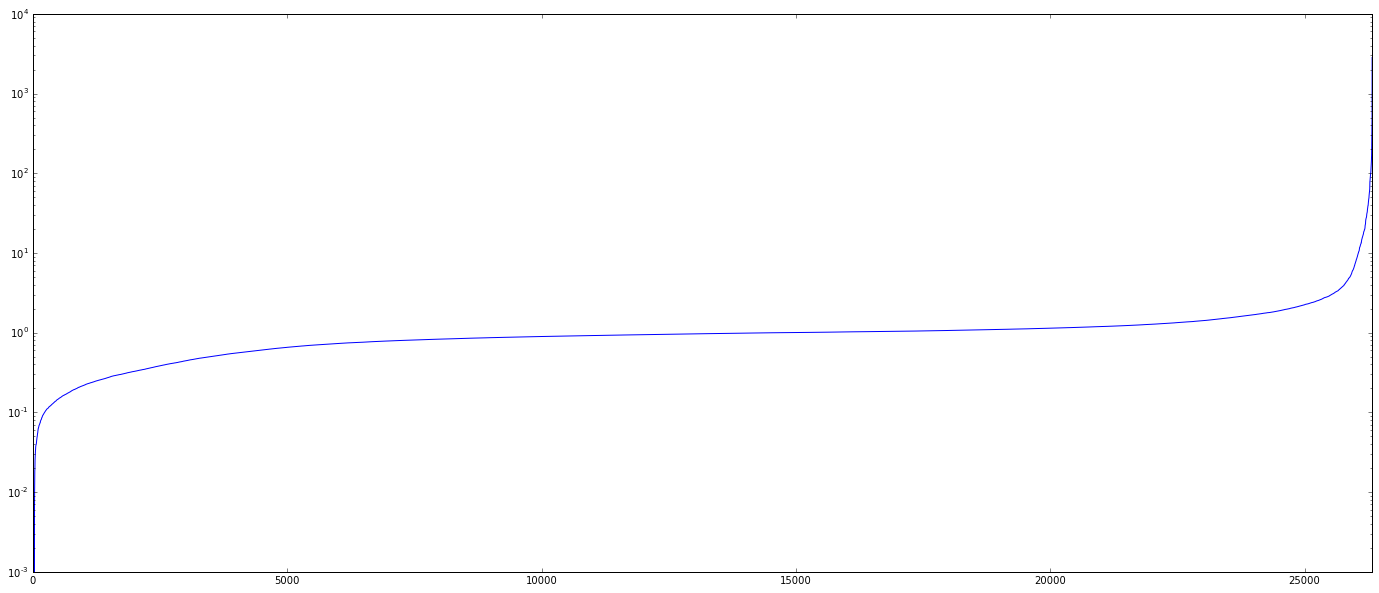

In [67]:
m_ratio.plot(logy=True, figsize=(24, 10))

What percentage of records are accurate to within plus/minus 25%?

In [68]:
len(m_ratio[(m_ratio > 0.75) & (m_ratio < 1.25)]) / len(m_ratio)

0.5863876334080291

There we go&mdash;a number to try and beat.

Here's a plot of market value versus predicted value ranked by market value:

A little more information about our dataset before we select a band: is under to over -estimation somehow correlated with actual market value, as I assume is the case (it's easier to be wrong about a big building than a small one)?

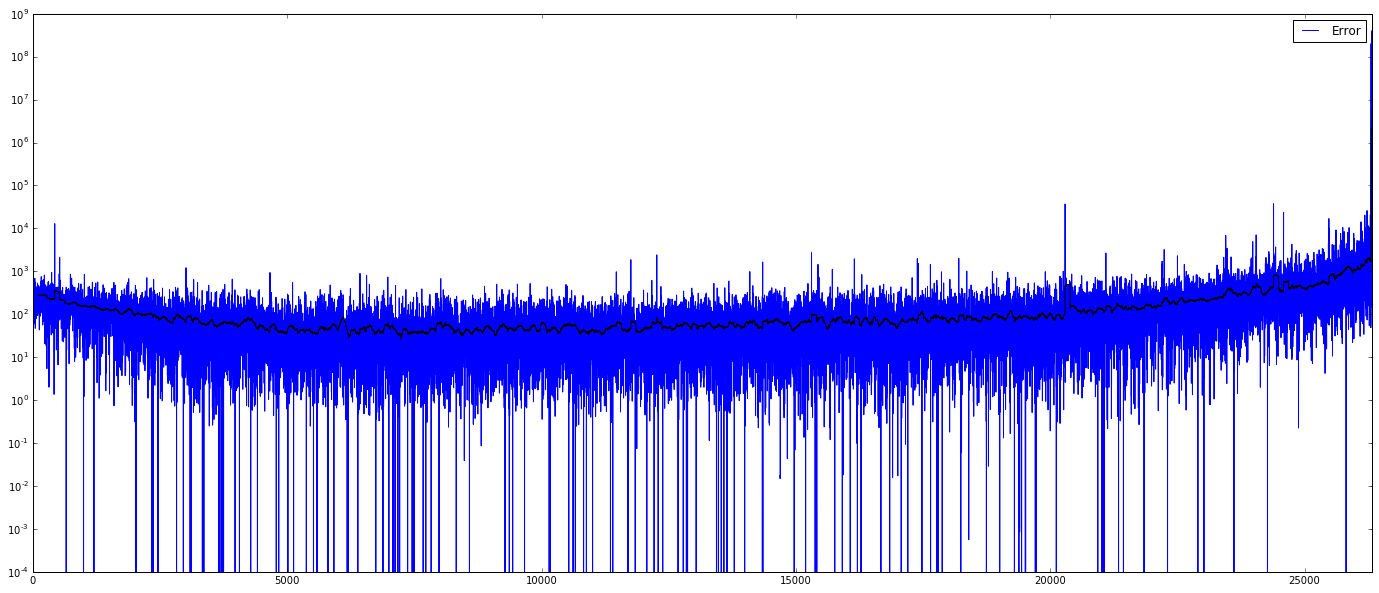

In [108]:
r_p_pre_s = r_p_pre.copy()
r_p_pre_s['ValueRatio'] = r_p_pre['EstCurentMarketValueSqFt'] / r_p_pre['MarketValueSqFt']
r_p_pre_s['Error'] = np.abs(r_p_pre['EstCurentMarketValueSqFt'] - r_p_pre['MarketValueSqFt'])
axes = r_p_pre_s.sort_values(by='SalePrice').reset_index().plot(figsize=(24, 10), y='Error', logy=True, color='b')
rolling = r_p_pre_s.sort_values(by='SalePrice').reset_index()['Error'].rolling(center=False, window=100).mean()
rolling.plot(ax=axes, color='black')

This plot shows the absolute difference between expected and actual market value per square foot.

As expected, the city's model does best when predicting intermediate varibles, and low and high values cause the error to rise. If things seem flat, they're not: remember that this is a logorithmic plot (the additional plot below demonstrates what I mean&mdash;and it only fits on the axis by not attempting to fit the 250 largest-value sales!).

This means that there are two sources of strong systemic error in the city's model. The first is error on the lowest-value sales, which, as previously discussed, come about as a result of non-market sales. The second is error on the highest-value sales, which comes from the model performing very poorly when attempting to price skyscrapers.

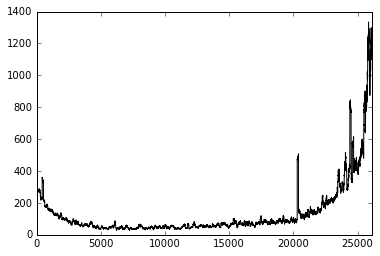

In [104]:
rolling[:-250].plot(color='black')

Looking at a wrongness ratio:

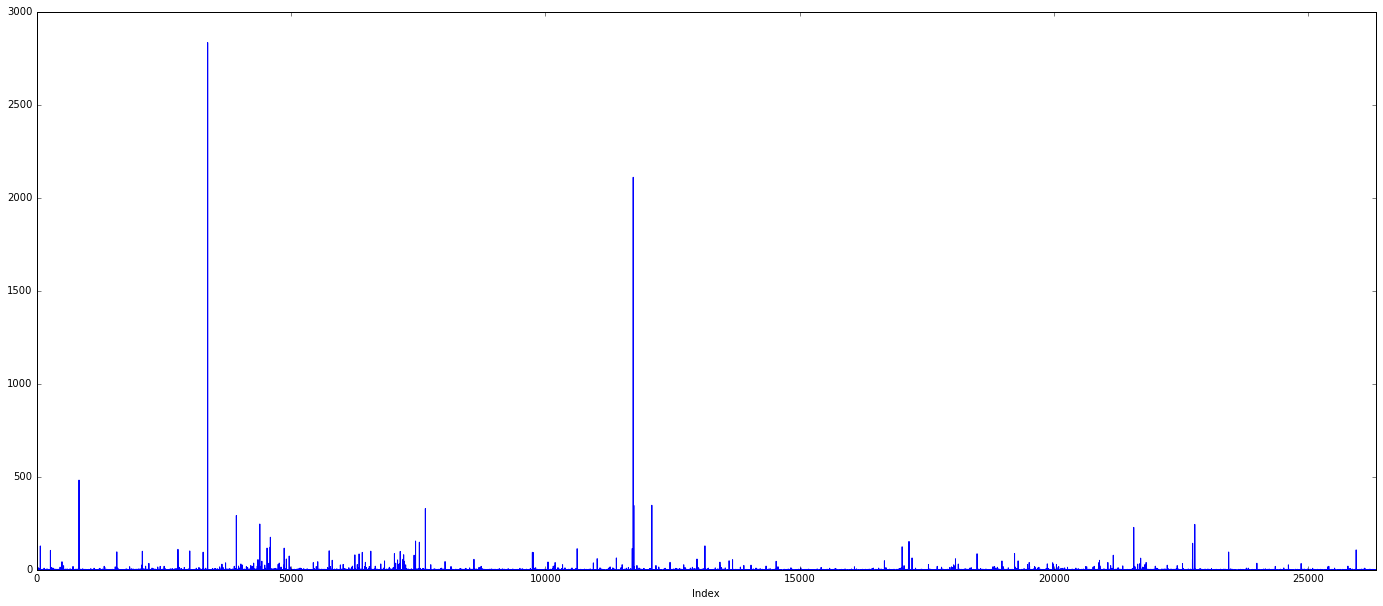

In [88]:
(r_p_pre_s['ValueRatio']).plot(figsize=(24, 10))

This doesn't make picking a good cutoff easier; mostly it just shows that there are some really extreme outliers out there. At what point do we stop losing missinformation and start losing the real thing? One more look to decide...

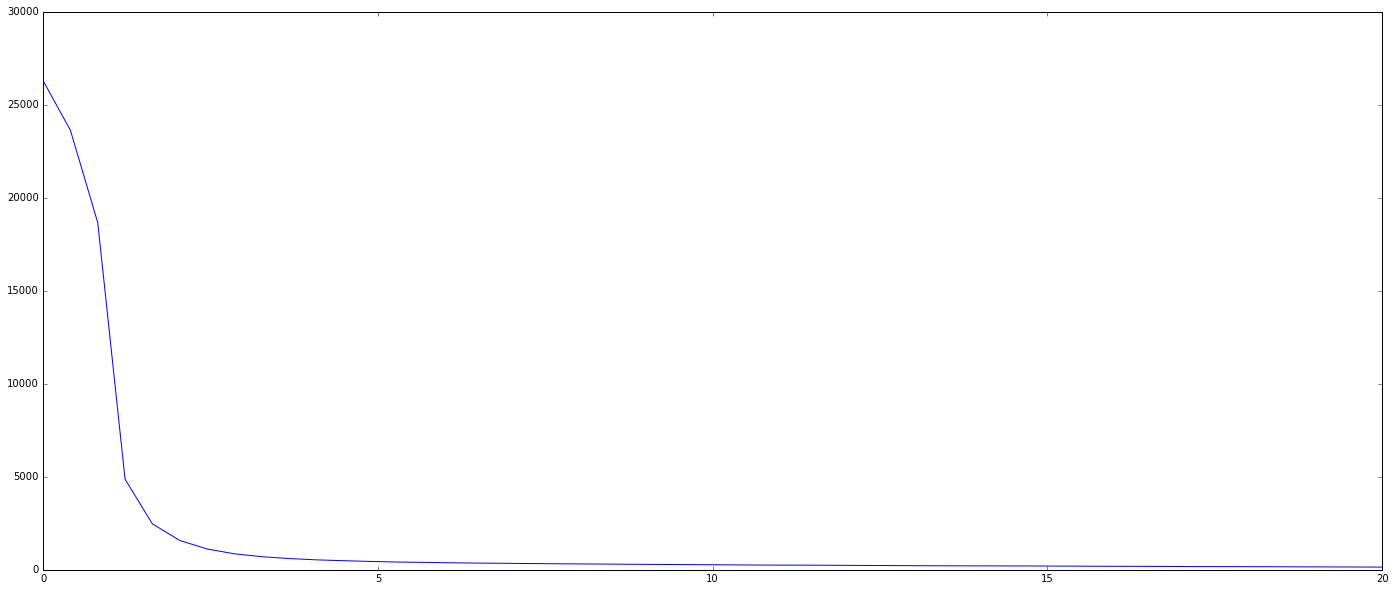

In [89]:
pd.Series({n: len(r_p_pre_s[r_p_pre_s['ValueRatio'] > n]) for n in np.linspace(0, 20)}).plot(figsize=(24, 10))

In [105]:
r_p_pre_s['OffRatio'] =  ((np.abs(r_p_pre_s['EstCurentMarketValueSqFt'] - r_p_pre_s['MarketValueSqFt'])) / r_p_pre_s['MarketValueSqFt'])

I decided to be very conservative and band at no more than two standard deviations/the 1% percentile of the data&mdash;corresponding with a cutoff of `'OffRatio' = 10`.

In [123]:
len(r_p_pre_s[r_p_pre_s['ValueRatio'] > 10]) / len(r_p_pre_s)

0.020851532530669604

In [109]:
r_p_pre_ss = r_p_pre_s[r_p_pre_s['ValueRatio'] < 10]

Looking at the plot again afterwards:

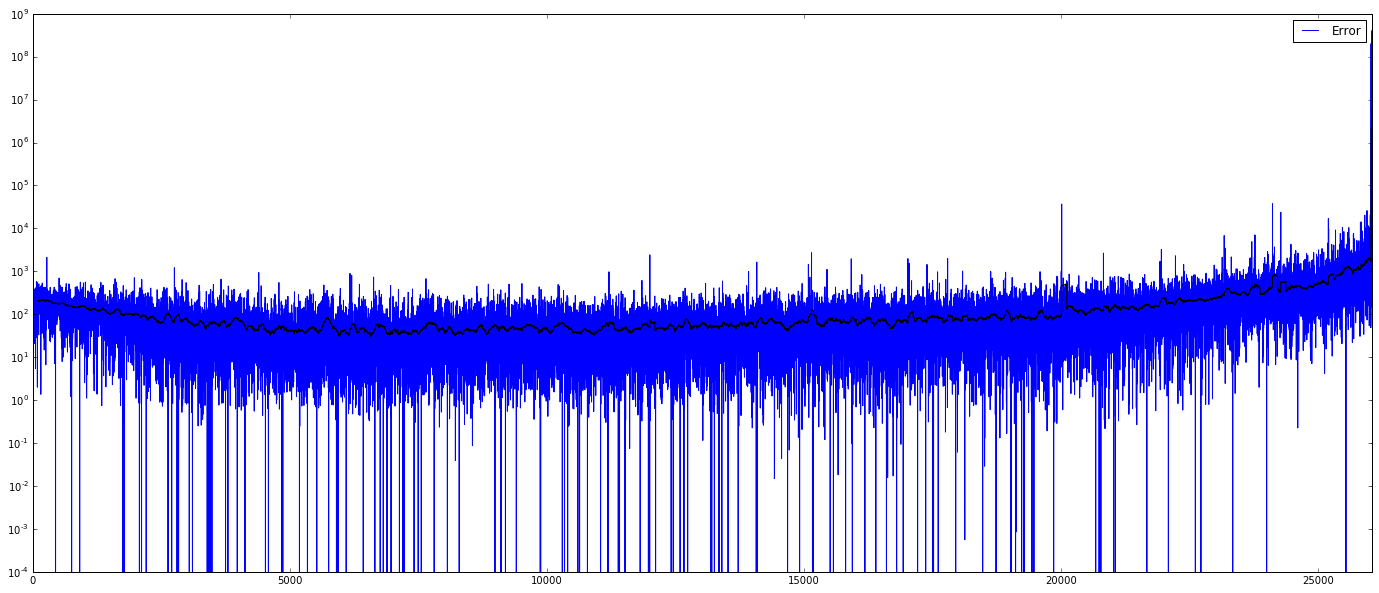

In [113]:
axes_2 = r_p_pre_ss.sort_values(by='SalePrice').reset_index().plot(figsize=(24, 10), y='Error', logy=True, color='b')
rolling_2 = r_p_pre_ss.sort_values(by='SalePrice').reset_index()['Error'].rolling(center=False, window=100).mean()
rolling_2.plot(ax=axes_2, color='black')

Not much changes! And that's a good thing; of course that's because we only dropped 1% of the total data.

We may filter again later into the process.

Now all that remains is deleting our temporary columns and saving the data.

In [120]:
r_p_pre_sss = r_p_pre_ss[r_p_pre.columns]

# Save

In [121]:
r_p_pre_sss.to_csv('nyc_building_sales.csv')
r_p_post.to_csv('nyc_building_nonsales.csv')

In [5]:
r_p = pd.read_csv('nyc_building_sales.csv')

/Users/Honors/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (22,25,27,28,69,70,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Further processing

After some further work in SAS EM we determined that there are still some issues with the data that we would like to handle.

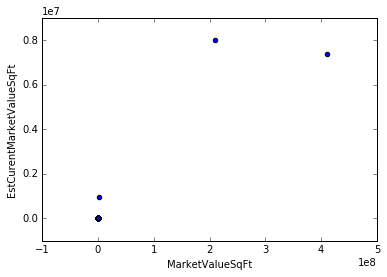

In [6]:
r_p[['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(x='MarketValueSqFt', y='EstCurentMarketValueSqFt', kind='scatter')

Wow.

(0, 5000)

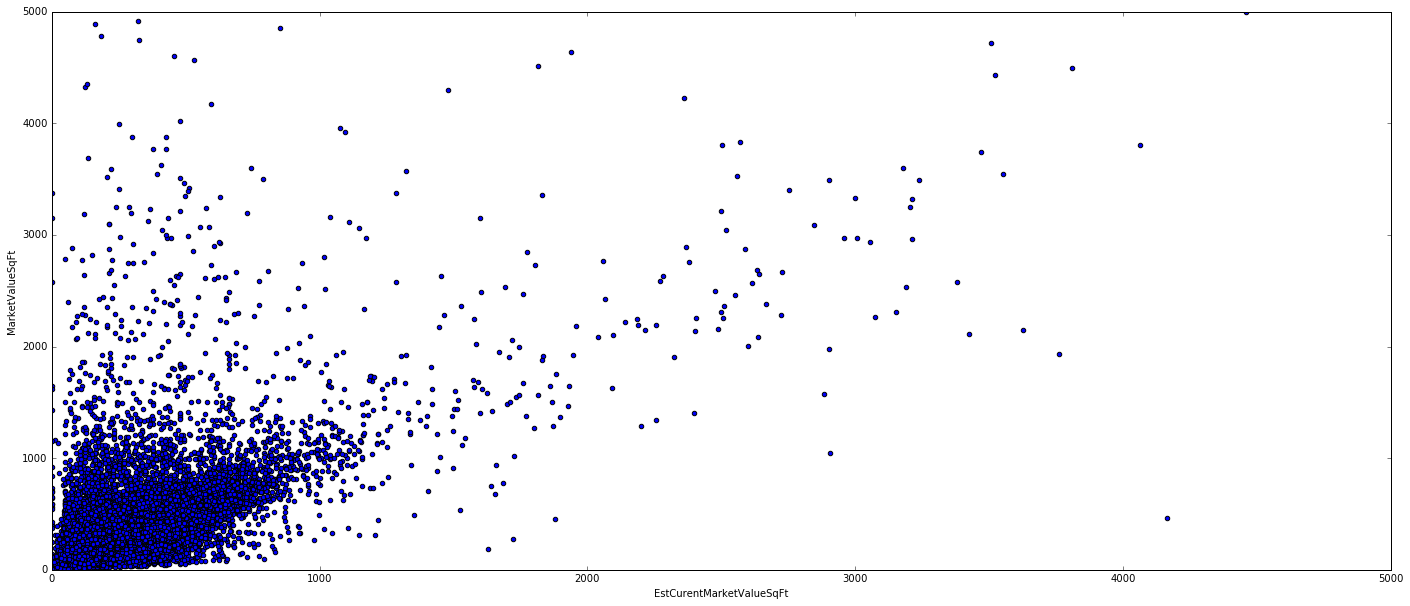

In [7]:
ax = r_p[r_p['MarketValueSqFt'] < 10000][['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                                                               x='EstCurentMarketValueSqFt',
                                                                                               kind='scatter',
                                                                                               figsize=(24, 10))
ax.set_xlim([0,5000])
ax.set_ylim([0,5000])

The [most expensive real estate in Manhattan](http://www.businessinsider.com/inside-one57-most-expensive-building-2015-11) costs ~$6000 per square foot at its peak, so entries over that value are 100% data definition errors in the RPAD file (adding an extra 0 perhaps).

In [39]:
r_p = r_p[r_p['MarketValueSqFt'] < 6000]
r_p = r_p[r_p['EstCurentMarketValueSqFt'] < 6000] # Removes but two values.

There was a sufficiently large number of cases in which estimated market value was out of band with the actual sale market value for it to be suspect.

On reflection, the reason for it seems pretty obvious. If the plot was a construction zone or an empty lot at the time that it was assessed for RPAD, the land will obviously carry little value. Yet it can suddenly become very valuable once a building is constructed there, goes onto the market, and gets sold. Since rolling sales occur on a rolling basis, both before and after whatever the RPAD assessment date is, and since we expect that at least some units would be sold quickly after being introduced onto the market, there are going to be a significant number of cases in which the RPAD assessments are based on an empty or unconstructed lot, and the actual market sale is going to be based on the value of the building that took its place.

These are completely different entities, so this difference doesn't actually encode any information.

This is the cloud of points above the graph in the visualization above. Notice how much sparser the space below is: this comes from our earlier very conservative banding was nevertheless successful in eliminating outlier points of the inverse type to the ones we are now considering. We apply this procedure again backwards.

In [8]:
# r_p['ValueRatio'] = r_p['MarketValueSqFt'] / r_p['EstCurentMarketValueSqFt']

In [11]:
r_p['ValueRatio'] = r_p['MarketValueSqFt'] / r_p['EstCurentMarketValueSqFt']

In [16]:
r_p = r_p[r_p['ValueRatio'] < 10]

(0, 5000)

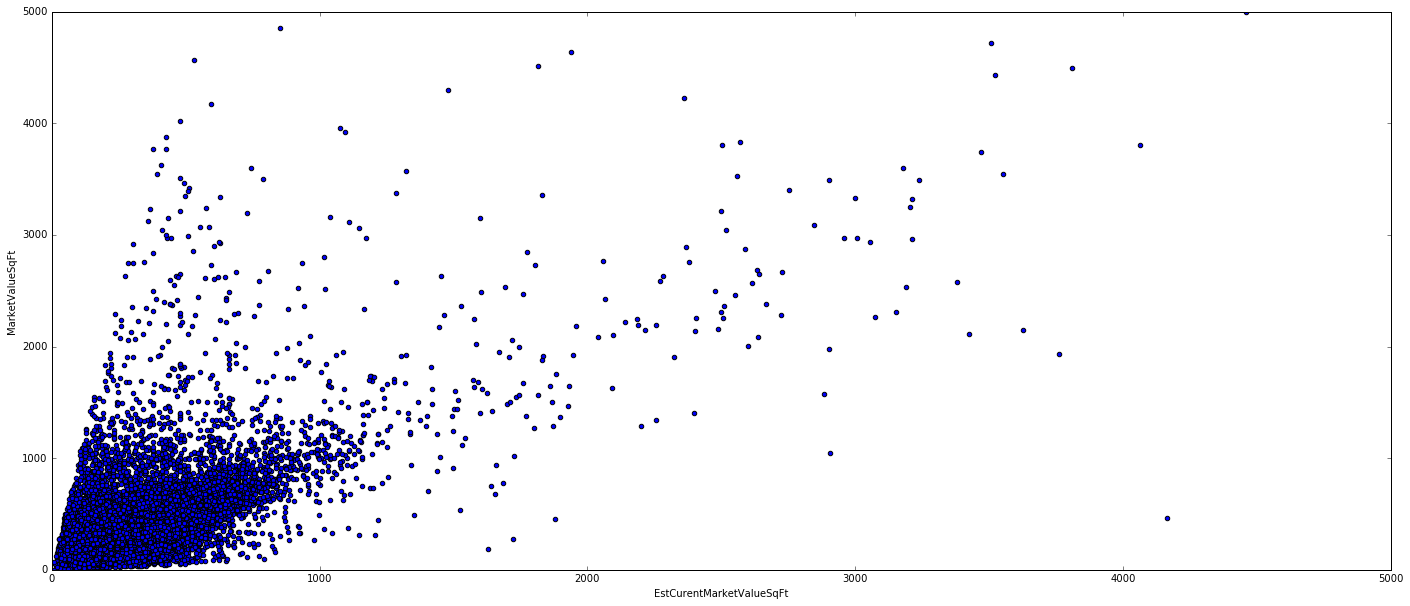

In [29]:
ax = r_p[(r_p['ValueRatio'] < 10)][['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                                                               x='EstCurentMarketValueSqFt',
                                                                                               kind='scatter',
                                                                                               figsize=(24, 10))
ax.set_xlim([0,5000])
ax.set_ylim([0,5000])

We can zoom in on the densest part of the cloud to see local distribution. Again notice that understimates are far denser than overestimates.

(0, 800)

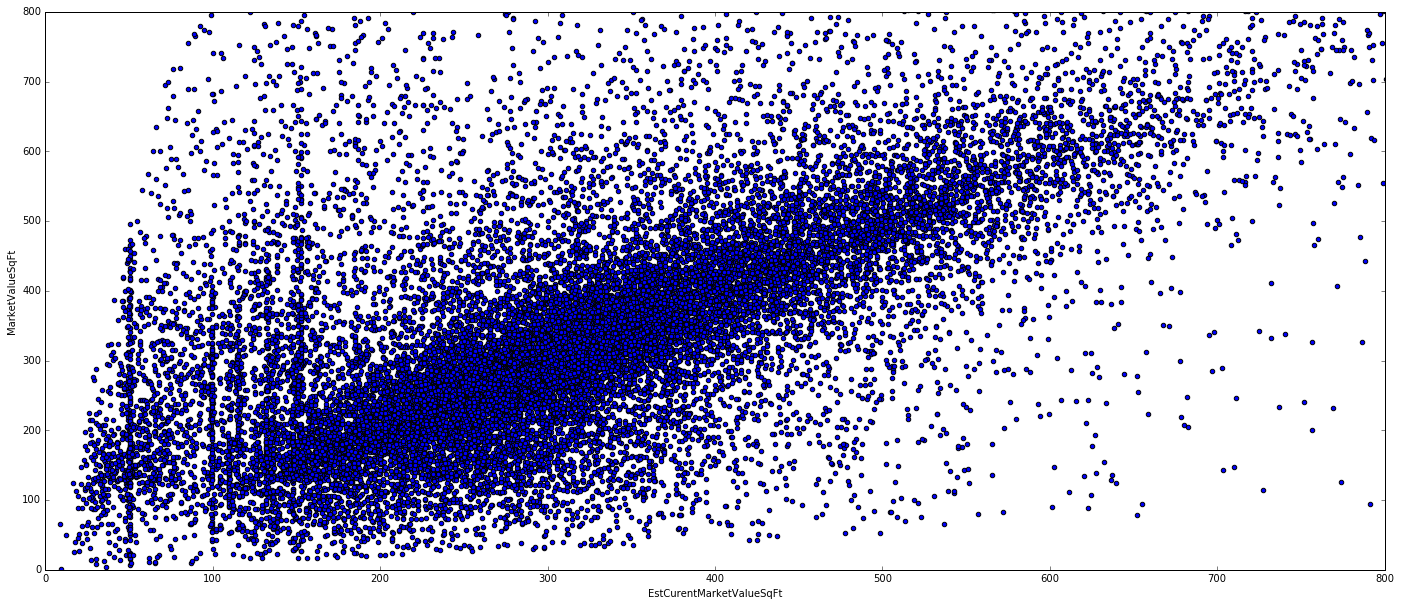

In [32]:
ax = r_p[['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                               x='EstCurentMarketValueSqFt',
                                                               kind='scatter',
                                                               figsize=(24, 10))
ax.set_xlim([0,800])
ax.set_ylim([0,800])

In [34]:
import seaborn as sns

The KDE plot bands the data entirely within a `700x700` box, showing that within our 24,000 observations the significant ones are located linearly, as expected.

I believe that the unnervingly dense cloud significantly above the x=y line is *mostly* a result of the natural variability and noise of market sales&mdash;notice that $\sigma^2(y)\sim \alpha x$&mdash;but I can't discount the possibility of market-encoded information within the scatter.

As a result of that high variability I expect that any model predicated on this data will display high squared errors.

But we will leave that up to the model.

[(0, 700), (0, 700)]

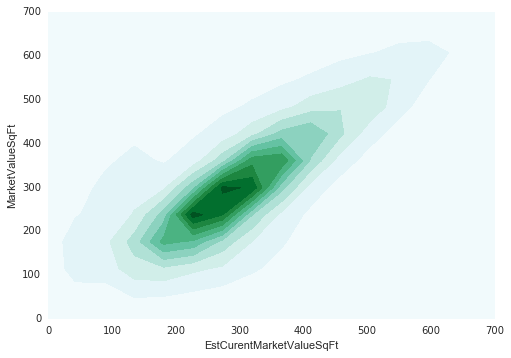

In [46]:
ax = sns.kdeplot(r_p['EstCurentMarketValueSqFt'], r_p['MarketValueSqFt'], shade=True, figsize=(24, 10))
ax.set(xlim=(0, 700), ylim=(0, 700))

In [47]:
r_p.to_csv('nyc_building_sales.csv')